In [1]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM

In [4]:
# Define stock tickers for analysis and fetching data of multiple stocks

In [5]:
tickers = ["TSLA", "AAPL", "MSFT", "GOOGL", "AMZN" ,"ORCL" ,"INTC" ,"NVDA" ,"META" ,"BABA"]  # Add more tickers as needed

In [6]:
# Function to fetch intraday data for multiple stocks

In [7]:
def fetch_stock_data(ticker):                                             # Using yahoo finance
    data = yf.download(ticker, interval='5m', period='5d')
    data.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
    data['Return'] = data['close'].pct_change()
    data['Target'] = (data['close'].shift(-1) > data['close']).astype(int)
    data.dropna(inplace=True)
    return data

In [8]:
# Fetch and process data for all tickers

In [9]:
all_data = {}
for ticker in tickers:
    all_data[ticker] = fetch_stock_data(ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
all_data[tickers[0]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 343 entries, 2025-01-03 14:35:00+00:00 to 2025-01-10 17:05:00+00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       343 non-null    float64
 1   high       343 non-null    float64
 2   low        343 non-null    float64
 3   close      343 non-null    float64
 4   adj_close  343 non-null    float64
 5   volume     343 non-null    int64  
 6   Return     343 non-null    float64
 7   Target     343 non-null    int32  
dtypes: float64(6), int32(1), int64(1)
memory usage: 22.8 KB


In [11]:
all_data[tickers[0]].head()

,open,high,low,close,adj_close,volume,Return,Target
Datetime,,,,,,,,
2025-01-03 14:35:00+00:00,388.279999,388.279999,388.420013,381.119995,383.578003,2907746,0.004401,1
2025-01-03 14:40:00+00:00,387.000000,387.000000,388.420013,385.803589,388.190094,1705775,0.012289,0
2025-01-03 14:45:00+00:00,385.529999,385.529999,388.299988,384.500000,386.975006,1811495,-0.003379,0
2025-01-03 14:50:00+00:00,385.644989,385.644989,387.079987,384.200012,385.600006,1318443,-0.000780,1
2025-01-03 14:55:00+00:00,389.654907,389.654907,389.899994,385.110107,385.753601,1923771,0.002369,1


In [12]:
all_data[tickers[0]].tail()

,open,high,low,close,adj_close,volume,Return,Target
Datetime,,,,,,,,
2025-01-10 16:45:00+00:00,390.369995,390.369995,391.339996,390.209991,390.500885,609670,0.005318,1
2025-01-10 16:50:00+00:00,391.450012,391.450012,391.959991,390.369995,390.499908,510299,0.000410,0
2025-01-10 16:55:00+00:00,389.450012,389.450012,391.424408,389.200104,391.320007,517916,-0.002997,0
2025-01-10 17:00:00+00:00,389.058807,389.058807,390.160004,388.929993,389.500000,357784,-0.000694,0
2025-01-10 17:05:00+00:00,389.535004,389.535004,389.809998,388.899994,389.140015,141175,-0.000077,0


In [13]:
# Analyze market hours only

In [14]:
def filter_market_hours(data):
    market = data.between_time('09:30:00', '16:00:00').copy()
    market.sort_index(inplace=True)
    return market

In [15]:
for ticker in tickers:
    all_data[ticker] = filter_market_hours(all_data[ticker])

In [16]:
# Creating features and target for Machine learning

In [17]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [18]:
def add_technical_indicators(data):
    data['SMA_5'] = data['close'].rolling(window=5).mean()  # 5-period simple moving average
    data['SMA_20'] = data['close'].rolling(window=20).mean()  # 20-period simple moving average
    data['RSI'] = compute_rsi(data['close'])  # RSI calculation
    data.dropna(inplace=True)  # Drop NaN values
    return data

In [19]:
for ticker in tickers:
    all_data[ticker] = add_technical_indicators(all_data[ticker])

In [20]:
combined_data = pd.concat([df.assign(ticker=ticker) for ticker, df in all_data.items()])
X = combined_data[['Return', 'SMA_5', 'SMA_20', 'RSI']]
y = combined_data['Target']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
#Using GradientBoostingClassifier(HYperparameter tuning included)

In [24]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

In [25]:
gb_model = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters found for Gradient Boosting: ", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found for Gradient Boosting:  {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}


In [26]:
# Cross-Validation for Gradient Boosting
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting: ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting:  [0.647343   0.56774194 0.47887324 0.18556701 0.66972477]
Mean F1 Score:  0.5098499902082105


In [27]:
gb_hyp_model = GradientBoostingClassifier(**grid_search.best_params_)
gb_hyp_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=50)

In [28]:
cv_scores = cross_val_score(gb_hyp_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting(tuned): ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting(tuned):  [0.61139896 0.69518717 0.64804469 0.55555556 0.65979381]
Mean F1 Score:  0.6339960384463892


In [29]:
predictions_gb_hyp = gb_hyp_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions_gb_hyp)
f1 = f1_score(y_test, predictions_gb_hyp)
precision = precision_score(y_test, predictions_gb_hyp)
recall = recall_score(y_test, predictions_gb_hyp)

print(f"Gradient Boosting Model Accuracy: {accuracy:.2f}")
print(f"Gradient Boosting F1 Score: {f1:.2f}")
print(f"Gradient Boosting Precision: {precision:.2f}")
print(f"Gradient Boosting Recall: {recall:.2f}")

Gradient Boosting Model Accuracy: 0.53
Gradient Boosting F1 Score: 0.54
Gradient Boosting Precision: 0.68
Gradient Boosting Recall: 0.44


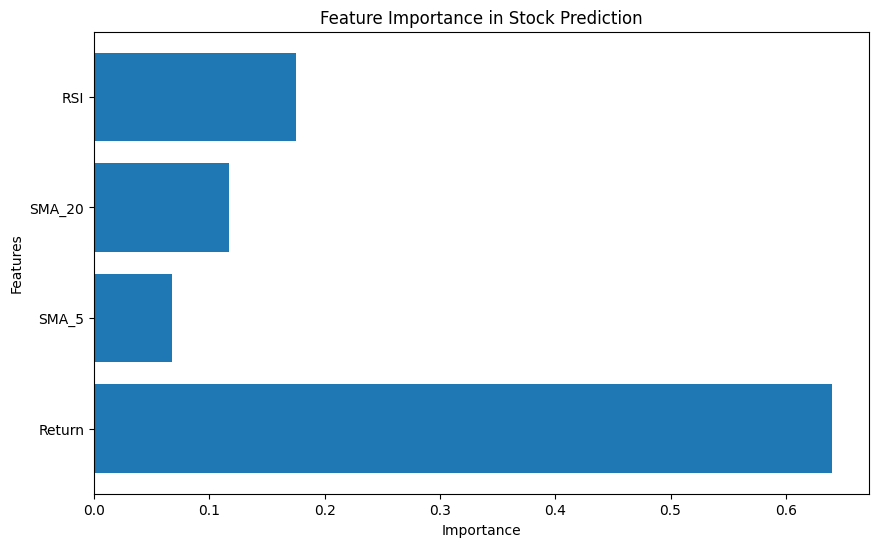

In [30]:
plt.figure(figsize=(10, 6))
plt.barh(['Return', 'SMA_5', 'SMA_20', 'RSI'], gb_hyp_model.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Stock Prediction')
plt.show()

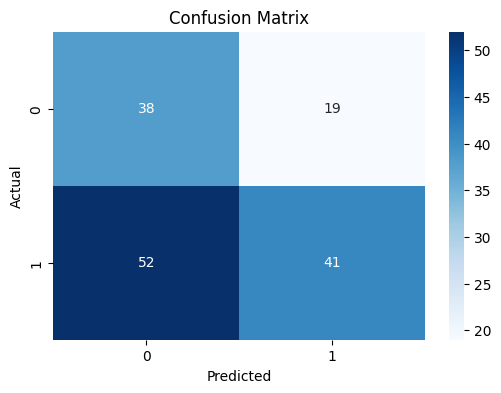

In [31]:
conf_matrix = confusion_matrix(y_test, predictions_gb_hyp)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
def predict_trending_stocks(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        stock_data = data[ticker]
        X_future = stock_data[['Return', 'SMA_5', 'SMA_20', 'RSI']].dropna().tail(1)  
        if not X_future.empty:
            X_future_scaled = scaler.transform(X_future)
            prediction = model.predict(X_future_scaled)[0]
            tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [33]:
trending_stocks = predict_trending_stocks(all_data, gb_hyp_model, scaler)
print("Trending Stocks for Tomorrow:")
print(trending_stocks)

Trending Stocks for Tomorrow:
{'TSLA': 'Down', 'AAPL': 'Up', 'MSFT': 'Down', 'GOOGL': 'Down', 'AMZN': 'Down', 'ORCL': 'Down', 'INTC': 'Up', 'NVDA': 'Up', 'META': 'Down', 'BABA': 'Down'}


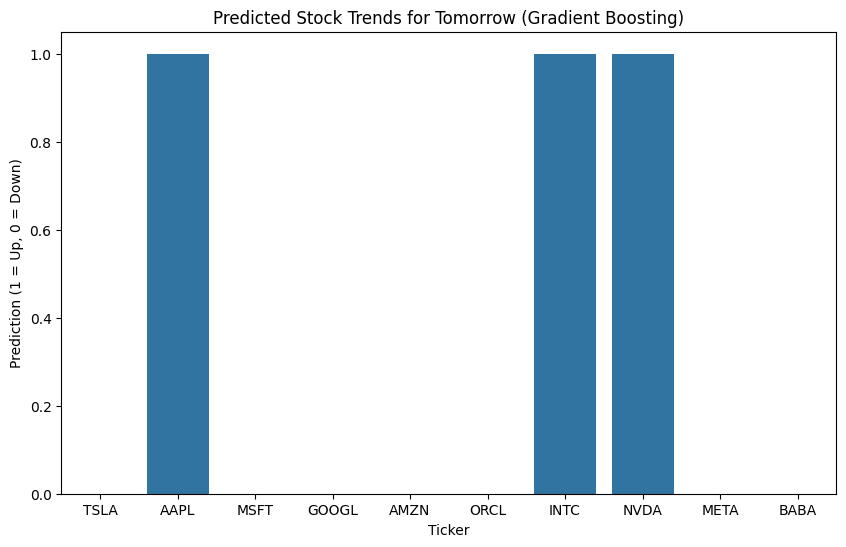

In [34]:
plt.figure(figsize=(10, 6))
trending_df = pd.DataFrame(list(trending_stocks.items()), columns=['Ticker', 'Prediction'])
trending_df['Prediction'] = trending_df['Prediction'].map({'Up': 1, 'Down': 0, 'No Data': None})
sns.barplot(x='Ticker', y='Prediction', data=trending_df.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (Gradient Boosting)')
plt.show()

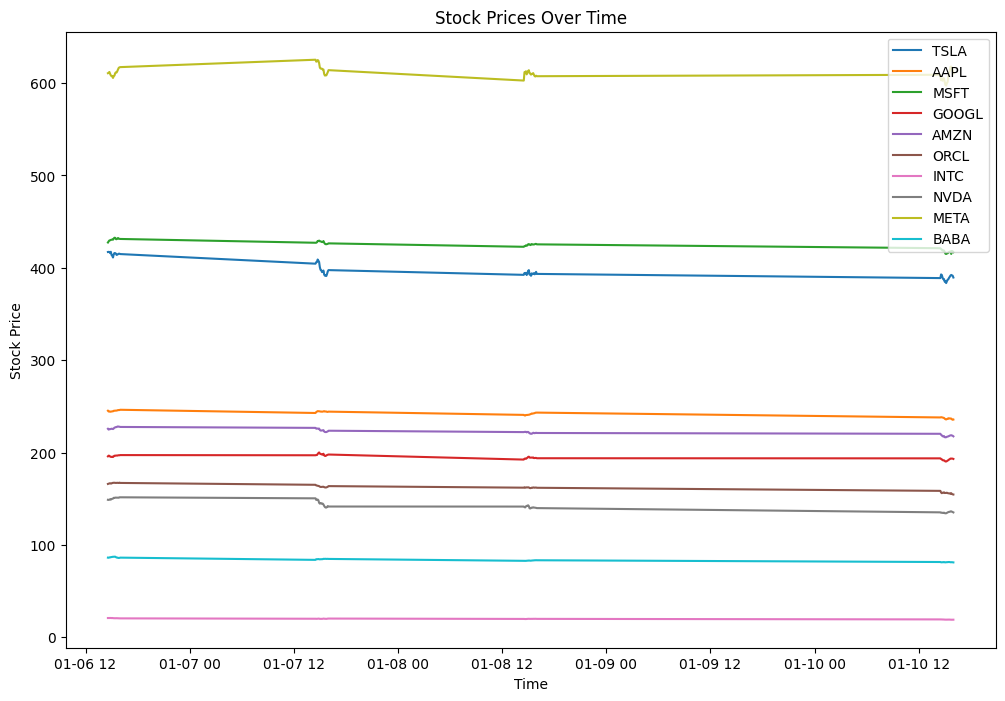

In [35]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

In [36]:
#Using Tenserflow

In [37]:
#Using LSTM
def prepare_lstm_data(X, y, time_steps=1):
    X_lstm = []
    y_lstm = []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:(i + time_steps)])
        y_lstm.append(y.iloc[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

In [38]:
time_steps = 5  # You can adjust this
X_lstm, y_lstm = prepare_lstm_data(X_train, y_train, time_steps)
X_lstm_test, y_lstm_test = prepare_lstm_data(X_test, y_test, time_steps)

In [39]:
lstm_model = Sequential([
    Input(shape=(time_steps, X.shape[1])),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [40]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
history_lstm = lstm_model.fit(X_lstm, y_lstm, validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.5244 - loss: 0.6910 - val_accuracy: 0.4538 - val_loss: 0.6957
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5346 - loss: 0.6902 - val_accuracy: 0.4538 - val_loss: 0.6978
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5183 - loss: 0.6914 - val_accuracy: 0.4538 - val_loss: 0.6986
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5336 - loss: 0.6884 - val_accuracy: 0.4538 - val_loss: 0.6994
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5324 - loss: 0.6880 - val_accuracy: 0.4622 - val_loss: 0.6972
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5479 - loss: 0.6845 - val_accuracy: 0.4622 - val_loss: 0.6988
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5253 - loss: 0.6929 - val_accuracy: 0.4538 - val_loss: 0.6985
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5088 - loss: 0.6880 - val_accuracy: 0.4286 -

In [42]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_lstm_test, y_lstm_test)
print(f"LSTM Model Loss: {lstm_loss:.4f}")
print(f"LSTM Model Accuracy: {lstm_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5465 - loss: 0.7128
LSTM Model Loss: 0.7625
LSTM Model Accuracy: 0.5172


In [43]:
predictions_lstm = (lstm_model.predict(X_lstm_test) > 0.5).astype(int).flatten()

accuracy_lstm = accuracy_score(y_lstm_test, predictions_lstm)
f1_lstm = f1_score(y_lstm_test, predictions_lstm)
precision_lstm = precision_score(y_lstm_test, predictions_lstm)
recall_lstm = recall_score(y_lstm_test, predictions_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm:.2f}")
print(f"LSTM F1 Score: {f1_lstm:.2f}")
print(f"LSTM Precision: {precision_lstm:.2f}")
print(f"LSTM Recall: {recall_lstm:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step
LSTM Model Accuracy: 0.52
LSTM F1 Score: 0.55
LSTM Precision: 0.65
LSTM Recall: 0.48


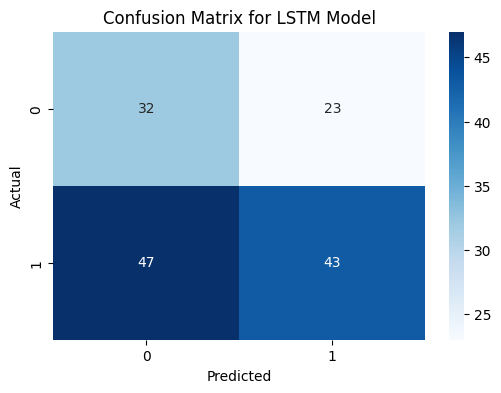

In [44]:
conf_matrix_lstm = confusion_matrix(y_lstm_test, predictions_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [45]:
def predict_trends_lstm(data, model, time_steps):
    tomorrow_predictions_lstm = {}
    for ticker in tickers:
        stock_data = data[ticker].tail(time_steps)
        if len(stock_data) >= time_steps:
            X_future = stock_data[['Return', 'SMA_5', 'SMA_20', 'RSI']].tail(time_steps).values
            X_future = X_future.reshape((1, time_steps, X_future.shape[1]))
            prediction = model.predict(X_future)
            tomorrow_predictions_lstm[ticker] = "Up" if prediction > 0.5 else "Down"
        else:
            tomorrow_predictions_lstm[ticker] = "No Data"
    return tomorrow_predictions_lstm

In [46]:
trending_stocks_lstm = predict_trends_lstm(all_data, lstm_model, time_steps)
print("LSTM Predicted Trending Stocks for Tomorrow:")
print(trending_stocks_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
LSTM Predicted Trending Stocks for Tomorrow:
{'TSLA': 'Down', 'AAPL': 'Down', 'MSFT': 'Down', 'GOOGL': 'Down', 'AMZN': 'Down', 'ORCL': 'Down', 'INTC': 'Up', 'NVDA': 'Down', 'META': 'Down', 'BABA': 'Up'}


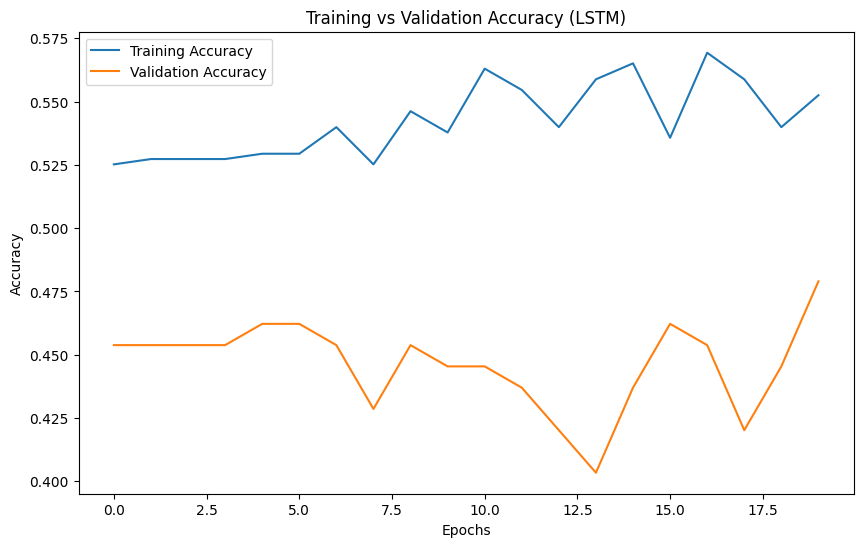

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (LSTM)')
plt.legend()
plt.show()

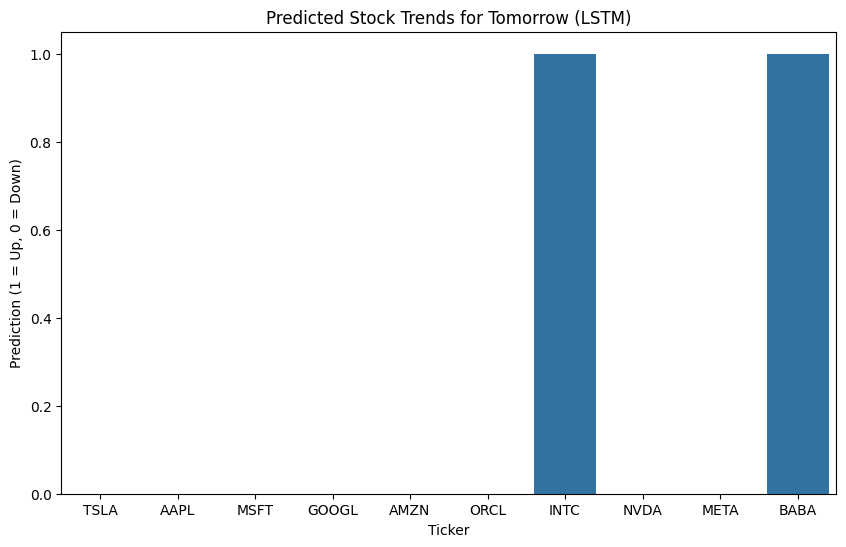

In [48]:
plt.figure(figsize=(10, 6))
trending_df_lstm = pd.DataFrame(list(trending_stocks_lstm.items()), columns=['Ticker', 'Prediction'])
trending_df_lstm['Prediction'] = trending_df_lstm['Prediction'].map({'Up': 1, 'Down': 0})
sns.barplot(x='Ticker', y='Prediction', data=trending_df_lstm.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (LSTM)')
plt.show()

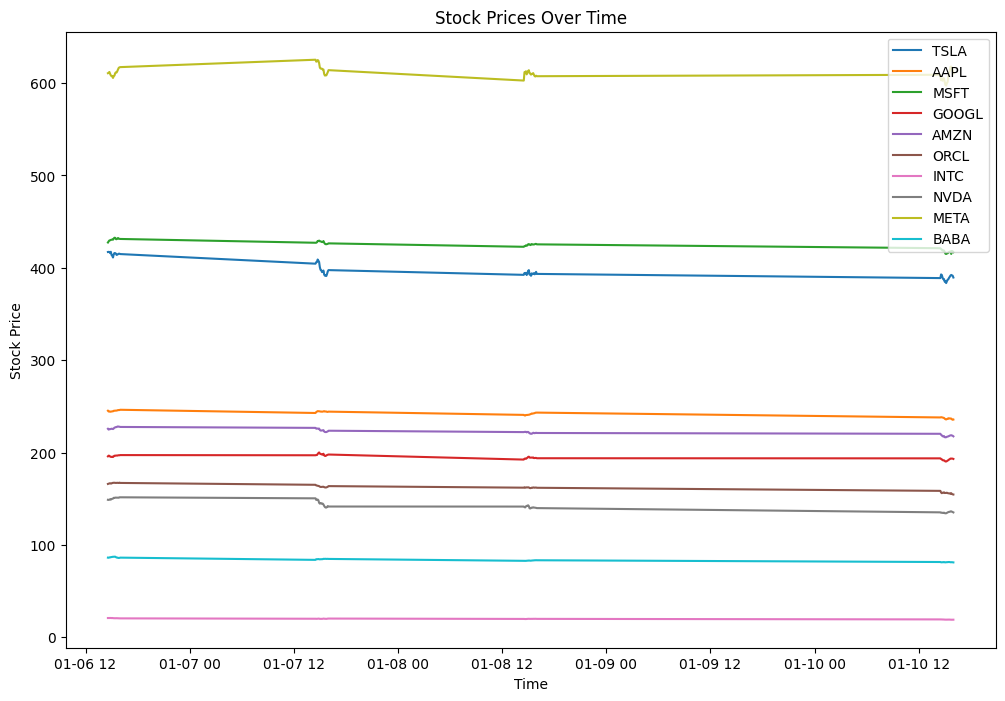

In [49]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

In [50]:
#Dense Neural Network
dnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape using Input layer
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
loss, accuracy = dnn_model.evaluate(X_test, y_test)
print(f"Dense Neural Network Model Accuracy: {accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3758 - loss: 0.7400 
Dense Neural Network Model Accuracy: 0.38


In [52]:
history_dnn = dnn_model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32)
print(history_dnn.history.keys())

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5059 - loss: 0.7088 - val_accuracy: 0.5667 - val_loss: 0.6926
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5155 - loss: 0.6888 - val_accuracy: 0.5167 - val_loss: 0.6936
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5010 - loss: 0.6894 - val_accuracy: 0.5167 - val_loss: 0.6959
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5693 - loss: 0.6823 - val_accuracy: 0.5167 - val_loss: 0.7006
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5704 - loss: 0.6648 - val_accuracy: 0.5250 - val_loss: 0.7010
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5932 - loss: 0.6749 - val_accuracy: 0.5333 - val_loss: 0.7020
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5728 - loss: 0.6802 - val_accuracy: 0.5167 - val_loss: 0.6997
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5827 - loss: 0.6774 - val_accuracy: 0.5167 - v

In [53]:
predictions_dnn = (dnn_model.predict(X_test) > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


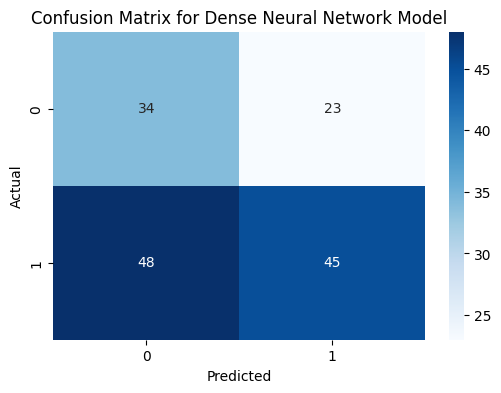

In [54]:
conf_matrix_dnn = confusion_matrix(y_test, predictions_dnn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_dnn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Dense Neural Network Model')
plt.show()

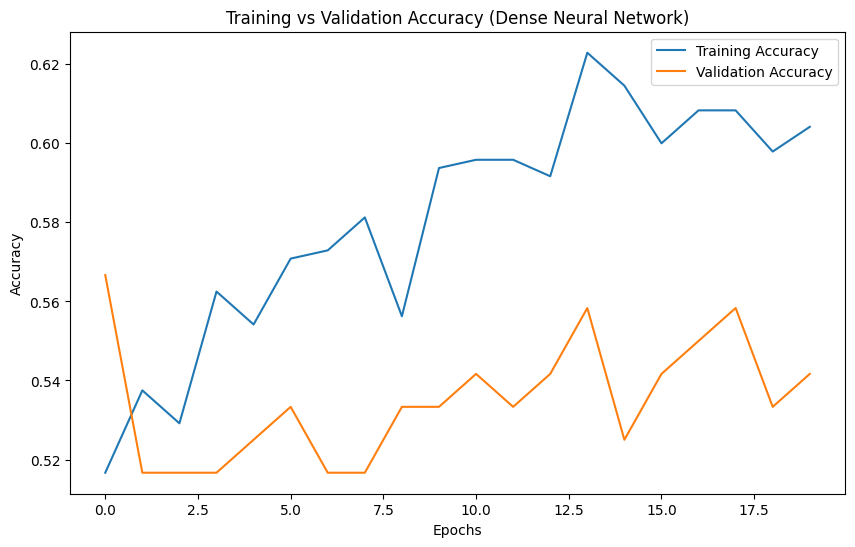

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Dense Neural Network)')
plt.legend()
plt.show()

In [56]:
def predict_trending_stocks_dnn(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        stock_data = data[ticker]
        X_future = stock_data[['Return', 'SMA_5', 'SMA_20', 'RSI']].dropna().tail(1)
        if not X_future.empty:
            X_future = scaler.transform(X_future)
            prediction = (model.predict(X_future) > 0.5).astype(int)[0][0]
            tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [57]:
trending_stocks_dnn = predict_trending_stocks_dnn(all_data, dnn_model, scaler)
print("Trending Stocks for Tomorrow (Dense Neural Network):")
print(trending_stocks_dnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Trending Stocks for Tomorrow (Dense Neural Network):
{'TSLA': 'Down', 'AAPL': 'Up', 'MSFT': 'Down', 'GOOGL': 'Down', 'AMZN': 'Down', 'ORCL': 'Down', 'INTC': 'Down', 'NVDA': 'Down', 'META': 'Down', 'BABA': 'Down'}


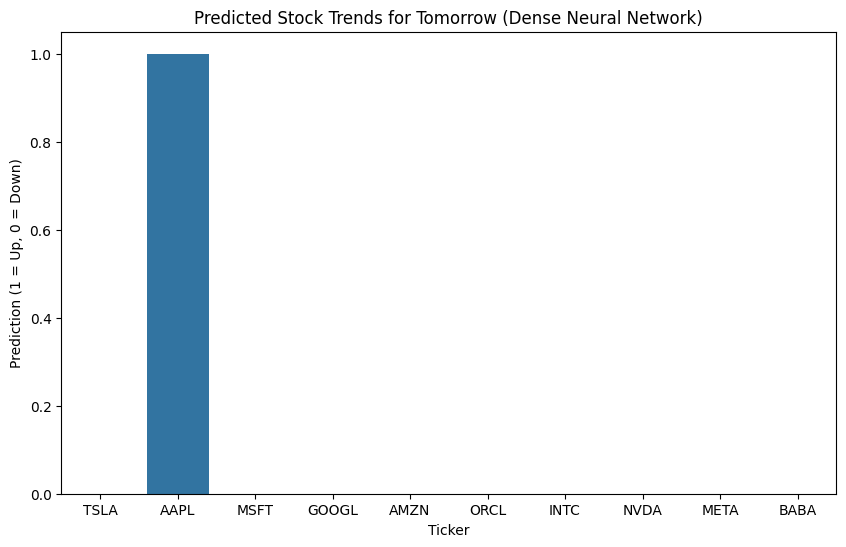

In [58]:
plt.figure(figsize=(10, 6))
trending_df_dnn = pd.DataFrame(list(trending_stocks_dnn.items()), columns=['Ticker', 'Prediction'])
trending_df_dnn['Prediction'] = trending_df_dnn['Prediction'].map({'Up': 1, 'Down': 0})
sns.barplot(x='Ticker', y='Prediction', data=trending_df_dnn.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (Dense Neural Network)')
plt.show()

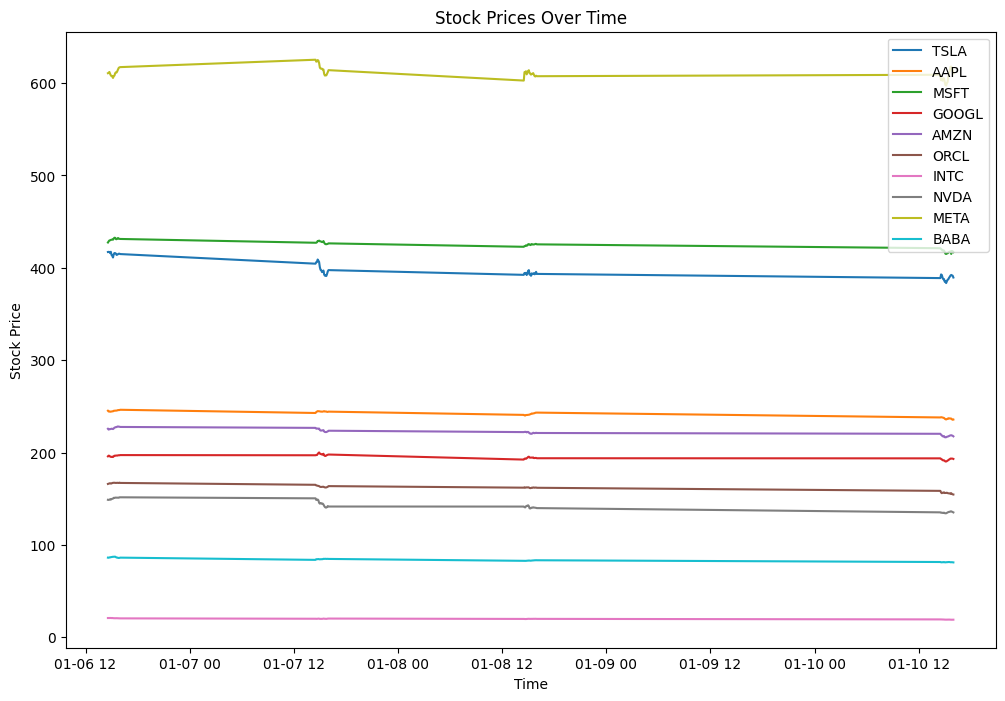

In [59]:

plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()
